## Measuring Between Data Representations

In this notebook we will introduce various distance and similarity measures and information theoretic metrics for various representations of data and probability distributions. We'll start with some very simple metrics to measure between sequences and words (as sequences of letters).

The Hamming distance between 1-D arrays u and v, is simply the proportion of disagreeing components in u and v. 

In [1]:
from scipy.spatial import distance

In [2]:
distance.hamming([1, 0, 0], [0, 1, 0])

0.6666666666666666

In [3]:
distance.hamming([1, 1, 0], [0, 1, 0])

0.3333333333333333

In [4]:
distance.hamming([0, 1, 0], [0, 1, 0])

0.0

#### Words as sequences of letters

We can use similar distance metrics for sequences for words. The python package [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) is specifically built for word and string similarities.

In [5]:
from fuzzywuzzy import fuzz

In [6]:
fuzz.ratio("this is a test", "this is a test!")

97

In [7]:
fuzz.partial_ratio("this is a test", "this is a test!")

100


The next sections of the notebook will contain distance metrics which are built into another package we have used extensively, Gensim, and uses material previously written by the author ([link 1](https://github.com/bhargavvader/personal/blob/master/notebooks/gensim/distance_metrics.ipynb), [link 2](https://radimrehurek.com/gensim_3.8.3/auto_examples/tutorials/run_distance_metrics.html)). 

In [8]:
from gensim.corpora import Dictionary
from gensim.models import ldamodel
import numpy as np

In [9]:
texts = [
    ['bank','river','shore','water'],
    ['river','water','flow','fast','tree'],
    ['bank','water','fall','flow'],
    ['bank','bank','water','rain','river'],
    ['river','water','mud','tree'],
    ['money','transaction','bank','finance'],
    ['bank','borrow','money'],
    ['bank','finance'],
    ['finance','money','sell','bank'],
    ['borrow','sell'],
    ['bank','loan','sell'],
]

In [10]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [11]:
np.random.seed(1) # setting random seed to get the same results each time.

In [12]:
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=2, minimum_probability=1e-8)
model.show_topics()

[(0,
  '0.207*"bank" + 0.100*"water" + 0.089*"river" + 0.088*"sell" + 0.067*"borrow" + 0.064*"finance" + 0.062*"money" + 0.053*"tree" + 0.045*"flow" + 0.044*"rain"'),
 (1,
  '0.142*"bank" + 0.116*"water" + 0.090*"river" + 0.084*"money" + 0.081*"finance" + 0.064*"flow" + 0.055*"transaction" + 0.055*"tree" + 0.053*"fall" + 0.050*"mud"')]

Let’s call the 1st topic the water topic and the second topic the finance topic.

Let’s take a few sample documents and get them ready to test our distance functions.

In [13]:
doc_water = ['river', 'water', 'shore']
doc_finance = ['finance', 'money', 'sell']
doc_bank = ['finance', 'bank', 'tree', 'water']

# now let's make these into a bag of words format
bow_water = model.id2word.doc2bow(doc_water)
bow_finance = model.id2word.doc2bow(doc_finance)
bow_bank = model.id2word.doc2bow(doc_bank)

# we can now get the LDA topic distributions for these
lda_bow_water = model[bow_water]
lda_bow_finance = model[bow_finance]
lda_bow_bank = model[bow_bank]

### Hellinger
We’re now ready to apply our distance metrics. These metrics return a value between 0 and 1, where values closer to 0 indicate a smaller ‘distance’ and therefore a larger similarity.

Let’s start with the popular Hellinger distance.

The Hellinger distance metric gives an output in the range [0,1] for two probability distributions, with values closer to 0 meaning they are more similar.

In [14]:
from gensim.matutils import hellinger

In [15]:
print(hellinger(lda_bow_water, lda_bow_finance))
print(hellinger(lda_bow_finance, lda_bow_bank))

0.24622682814248142
0.007332672705927328


Makes sense, right? In the first example, Document 1 and Document 2 are hardly similar, so we get a value of roughly 0.5.

In the second case, the documents are a lot more similar, semantically. Trained with the model, they give a much less distance value.

### Kullback–Leibler

In [16]:
from gensim.matutils import kullback_leibler

print(kullback_leibler(lda_bow_water, lda_bow_bank))
print(kullback_leibler(lda_bow_finance, lda_bow_bank))

0.22783092
0.00021459442


Note: KL is not a Distance Metric in the mathematical sense, and hence is not symmetrical. This means that ```kullback_leibler(lda_bow_finance, lda_bow_bank)``` is not equal to ```kullback_leibler(lda_bow_bank, lda_bow_finance)```.

In [17]:
print(kullback_leibler(lda_bow_bank, lda_bow_finance))

0.00021555647


In our previous examples we saw that there were lower distance values between bank and finance than for bank and water, even if it wasn’t by a huge margin. What does this mean?

The bank document is a combination of both water and finance related terms - but as bank in this context is likely to belong to the finance topic, the distance values are less between the finance and bank bows.

In [18]:
# just to confirm our suspicion that the bank bow is more to do with finance:
model.get_document_topics(bow_bank)

[(0, 0.64126813), (1, 0.35873187)]

It’s evident that while it isn’t too skewed, it it more towards the finance topic.

Distance metrics (also referred to as similarity metrics), as suggested in the examples above, are mainly for probability distributions, but the methods can accept a bunch of formats for input. 

### Jaccard
Let us now look at the Jaccard Distance metric for similarity between bags of words (i.e, documents)

In [19]:
from gensim.matutils import jaccard

In [20]:
print(jaccard(bow_water, bow_bank))
print(jaccard(doc_water, doc_bank))
print(jaccard(['word'], ['word']))

0.8571428571428572
0.8333333333333334
0.0


The three examples above feature 2 different input methods.

In the first case, we present to jaccard document vectors already in bag of words format. The distance can be defined as 1 minus the size of the intersection upon the size of the union of the vectors.

We can see (on manual inspection as well), that the distance is likely to be high - and it is.

The last two examples illustrate the ability for jaccard to accept even lists (i.e, documents) as inputs.

In the last case, because they are the same vectors, the value returned is 0 - this means the distance is 0 and the two documents are identical.

### Distance Metrics for Topic Distributions

While there are already standard methods to identify similarity of documents, our distance metrics has one more interesting use-case: topic distributions.

Let’s say we want to find out how similar our two topics are, water and finance.

In [21]:
topic_water, topic_finance = model.show_topics()

In [22]:
def parse_topic_string(topic):
    # some pre processing to get the topics in a format acceptable to our distance metrics
    # takes the string returned by model.show_topics()
    # split on strings to get topics and the probabilities
    topic = topic.split('+')
    # list to store topic bows
    topic_bow = []
    for word in topic:
        # split probability and word
        prob, word = word.split('*')
        # get rid of spaces and quote marks
        word = word.replace(" ","").replace('"', '')
        # convert to word_type
        word = model.id2word.doc2bow([word])[0][0]
        topic_bow.append((word, float(prob)))
    return topic_bow

In [23]:
finance_distribution = parse_topic_string(topic_finance[1])
water_distribution = parse_topic_string(topic_water[1])

In [24]:
# the finance topic in bag of words format looks like this:
print(finance_distribution)

[(0, 0.142), (3, 0.116), (1, 0.09), (11, 0.084), (10, 0.081), (5, 0.064), (12, 0.055), (6, 0.055), (7, 0.053), (9, 0.05)]


Now that we’ve got our topics in a format more acceptable by our functions, let’s use a Distance metric to see how similar the word distributions in the topics are.

In [25]:
print(hellinger(water_distribution, finance_distribution))


0.42898539619904935


Our value of roughly 0.36 means that the topics are not TOO distant with respect to their word distributions.

This makes sense again, because of overlapping words like bank and a small size dictionary.

### Kullback-Leibler Gotchas
In our previous example we didn’t use Kullback Leibler to test for similarity for a reason - KL is not a Distance ‘Metric’ in the technical sense (you can see what a metric is [here](https://en.wikipedia.org/wiki/Metric_(mathematics))). The nature of it, mathematically also means we must be a little careful before using it, because since it involves the log function, a zero can mess things up. For example:

In [26]:
# 16 here is the number of features the probability distribution draws from
print(kullback_leibler(water_distribution, finance_distribution, 16))

inf


That wasn’t very helpful, right? This just means that we have to be a bit careful about our inputs. Our old example didn’t work out because they were some missing values for some words (because show_topics() only returned the top 10 topics).

This can be remedied, though.

In [27]:
# return ALL the words in the dictionary for the topic-word distribution.
topic_water, topic_finance = model.show_topics(num_words=len(model.id2word))

# do our bag of words transformation again
finance_distribution = parse_topic_string(topic_finance[1])
water_distribution = parse_topic_string(topic_water[1])

# and voila!
print(kullback_leibler(water_distribution, finance_distribution))

0.087688535


You may notice that the distance for this is quite less, indicating a high similarity. This may be a bit off because of the small size of the corpus, where all topics are likely to contain a decent overlap of word probabilities. You will likely get a better value for a bigger corpus.

So, just remember, if you intend to use KL as a metric to measure similarity or distance between two distributions, avoid zeros by returning the ENTIRE distribution. Since it’s unlikely any probability distribution will ever have absolute zeros for any feature/word, returning all the values like we did will make you good to go.

### What are Distance Metrics?

Having seen the practical usages of these measures (i.e, to find similarity), let’s learn a little about what exactly Distance Measures and Metrics are.

I mentioned in the previous section that KL was not a distance metric. There are 4 conditons for for a distance measure to be a metric:

    d(x,y) >= 0

    d(x,y) = 0 <=> x = y

    d(x,y) = d(y,x)

    d(x,z) <= d(x,y) + d(y,z)

That is: it must be non-negative; if x and y are the same, distance must be zero; it must be symmetric; and it must obey the triangle inequality law.

Simple enough, right?

Let’s test these out for our measures.



In [28]:
a = hellinger(water_distribution, finance_distribution)
b = hellinger(finance_distribution, water_distribution)
print(a)
print(b)
print(a == b)

0.14950162744749795
0.14950162744749795
True


In [29]:
# if we pass the same values, it is zero.
print(hellinger(water_distribution, water_distribution))

# for triangle inequality let's use LDA document distributions
print(hellinger(lda_bow_finance, lda_bow_bank))

# Triangle inequality works too!
print(hellinger(lda_bow_finance, lda_bow_water) + hellinger(lda_bow_water, lda_bow_bank))

0.0
0.007332672705927328
0.4852296733896022


So Hellinger is indeed a metric. Let’s check out KL.

In [30]:
a = kullback_leibler(finance_distribution, water_distribution)
b = kullback_leibler(water_distribution, finance_distribution)
print(a)
print(b)
print(a == b)

0.09273797
0.087688535
False


We immediately notice that when we swap the values they aren’t equal! One of the four conditions not fitting is enough for it to not be a metric.

However, just because it is not a metric, (strictly in the mathematical sense) does not mean that it is not useful to figure out the distance between two probability distributions. KL Divergence is widely used for this purpose, and is probably the most ‘famous’ distance measure in fields like Information Theory.

For a nice review of the mathematical differences between Hellinger and KL, this Stackoverflow question - [link](https://stats.stackexchange.com/questions/130432/differences-between-bhattacharyya-distance-and-kl-divergence) does a very good job.



### Visualizing Distance Metrics

Let’s plot a graph of our toy dataset using the popular networkx library.

Each node will be a document, where the color of the node will be its topic according to the LDA model. Edges will connect documents to each other, where the weight of the edge will be inversely proportional to the Jaccard similarity between two documents. We will also annotate the edges to further aid visualization: strong edges will connect similar documents, and weak (dashed) edges will connect dissimilar documents.

In summary, similar documents will be closer together, different documents will be further apart.

In [31]:
import itertools
import networkx as nx


In [32]:
def get_most_likely_topic(doc):
    bow = model.id2word.doc2bow(doc)
    topics, probabilities = zip(*model.get_document_topics(bow))
    max_p = max(probabilities)
    topic = topics[probabilities.index(max_p)]
    return topic

def get_node_color(i):
    return 'skyblue' if get_most_likely_topic(texts[i]) == 0 else 'pink'

In [33]:
G = nx.Graph()
for i, _ in enumerate(texts):
    G.add_node(i)

for (i1, i2) in itertools.combinations(range(len(texts)), 2):
    bow1, bow2 = texts[i1], texts[i2]
    distance = jaccard(bow1, bow2)
    G.add_edge(i1, i2, weight=1/distance)

{0: Text(0.8139056554148585, -0.1385144383214792, '0'),
 1: Text(-0.2609162263425896, 0.8290751405979758, '1'),
 2: Text(0.12108432357837688, 0.2521192345954642, '2'),
 3: Text(0.7410538444428034, 0.3897745756787509, '3'),
 4: Text(0.3571060747096814, 0.8878304053766498, '4'),
 5: Text(-0.19185848377519837, -0.4814192613354953, '5'),
 6: Text(-0.7484781508847783, -0.5667501948434654, '6'),
 7: Text(-0.7291843541015196, 0.3730910679100171, '7'),
 8: Text(0.38214490760132847, -0.5064739523722547, '8'),
 9: Text(0.07139744748226842, -1.0, '9'),
 10: Text(-0.5562550381252319, -0.03873257728616475, '10')}

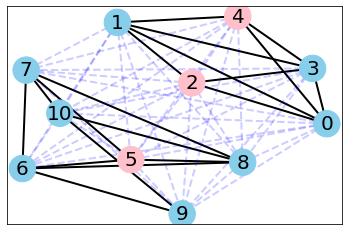

In [34]:
#
# https://networkx.github.io/documentation/networkx-1.9/examples/drawing/weighted_graph.html
#
pos = nx.spring_layout(G)

threshold = 1.25
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > threshold]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <= threshold]

node_colors = [get_node_color(i) for (i, _) in enumerate(texts)]
nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
nx.draw_networkx_edges(G,pos,edgelist=elarge, width=2)
nx.draw_networkx_edges(G,pos,edgelist=esmall, width=2, alpha=0.2, edge_color='b', style='dashed')
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

We can make several observations from this graph.

First, the graph consists of two connected components (if you ignore the weak edges). Nodes 0, 1, 2, 3, 4 (which all belong to the water topic) form the first connected component. The other nodes, which all belong to the finance topic, form the second connected component.

### Distances in embedding spaces

Let's now see the different ways we can measure between distances in embedding spaces.

In [35]:
import gensim

In [36]:
from gensim.models import Word2Vec


In [37]:
model_address = "/Users/bhargavvader/open_source/comp-syn/GoogleNews-vectors-negative300.bin" 

In [38]:
nytimes_w2v_model = gensim.models.KeyedVectors.load_word2vec_format(model_address, binary=True)

In [39]:
spoon_vector = nytimes_w2v_model["spoon"]

In [40]:
plumber_vector = nytimes_w2v_model["plumber"]

In [41]:
spatula_vector = nytimes_w2v_model["spatula"]

In [42]:
soap_vector = nytimes_w2v_model["soap"]

In [94]:
spoon_vector[0:8]

array([-0.06079102, -0.05859375,  0.20507812, -0.10253906, -0.19726562,
       -0.13769531,  0.28320312, -0.0004673 ], dtype=float32)

#### cosine similarity

Cosine similarity is often used to measure between two vectors in a high dimensional space - here, we 

In [43]:
def cosine_distance(X, Y):
    cosine_similarity = np.dot(X, Y) / (np.linalg.norm(X)* np.linalg.norm(Y))
    return 1 - cosine_similarity

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [45]:
def heatplot(ps, qs, distance_function, annot=True):
    # inputs are dictionaries with object -> data point
    L = []
    for p in ps:
        l = []
        for q in qs:
            l.append(distance_function(ps[p], qs[q]))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(ps.keys()), index = list(qs.keys()))
    ax = sns.heatmap(div, annot=annot)
    plt.show()

In [46]:
word_vectors = {"spoon":spoon_vector, "plumber":plumber_vector, "spatula":spatula_vector, "soap":soap_vector}

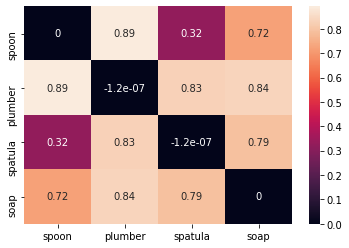

In [47]:
heatplot(word_vectors, word_vectors, cosine_distance)

### Some more measures for probability distributions

Let's also use each of these words color distributions(JzAzBz) to see how they match up.

In [48]:
import compsyn as cs
import PIL
from PIL import Image
import numpy as np

In [49]:
path = "/Users/bhargavvader/open_source/comp-syn/vectors_data/"

In [50]:
disk_vectors = cs.vectors.LoadVectorsFromDisk(path)

In [51]:
spoon_rgb = disk_vectors.vectors["spoon"].rgb_dist

In [52]:
spoon_jzazbz = disk_vectors.vectors["spoon"].jzazbz_dist

In [53]:
plumber_rgb = disk_vectors.vectors["plumber"].rgb_dist

In [54]:
plumber_jzazbz = disk_vectors.vectors["plumber"].jzazbz_dist

In [55]:
soap_rgb = disk_vectors.vectors["soap"].rgb_dist

In [56]:
soap_jzazbz = disk_vectors.vectors["soap"].jzazbz_dist

In [57]:
spatula_rgb = disk_vectors.vectors["spatula"].rgb_dist

In [58]:
spatula_jzazbz = disk_vectors.vectors["spatula"].jzazbz_dist

In [95]:
spoon_jzazbz

[1.5443596654454392,
 110.44117960225408,
 0.09030894441112076,
 23.274409875341043,
 0.6444088441605241,
 649.3077159017771,
 7.558348899594023,
 48.892767068044215]

In [59]:
rgb_vectors = {"spoon_rgb":spoon_rgb, "plumber_rgb":plumber_rgb, "spatula_rgb":spatula_rgb, "soap_rgb":soap_rgb}

In [60]:
jzazbz_vectors = {"spoon_j":spoon_jzazbz, "plumber_j":plumber_jzazbz, "spatula_j":spatula_jzazbz, "soap_j":soap_jzazbz}

Since they are distributions of colors, let us see how our KL divergence metric works on identifying similarities in the vectors.

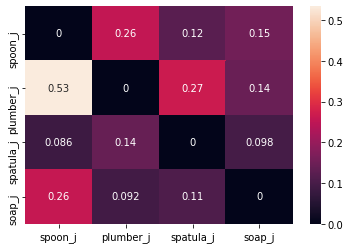

In [61]:
heatplot(jzazbz_vectors, jzazbz_vectors, kullback_leibler)

We see here that the KL metrics lack of symmetry can make these a little difficult to interpret - let us use a symmetric measure now.

### Jensen Shannon Divergence 

It is based on the Kullback–Leibler divergence, with some notable (and useful) differences, including that it is symmetric and it always has a finite value.

In [64]:
import scipy

In [65]:
def jensen_shannon(dist1, dist2):
    """
    Calculates Jensen-Shannon (JS) divergence between two distributions

    Args:
        dist1 (array): first distribution
        dist2 (array): second distribution

    Returns:
        js (float): JS divergence
    """
    dist1 = np.array(dist1)
    dist2 = np.array(dist2)

    mean_dist = (dist1 + dist2) / 2.0
    js = (
        scipy.stats.entropy(dist1, mean_dist) + scipy.stats.entropy(dist2, mean_dist)
    ) / 2.0
    return js

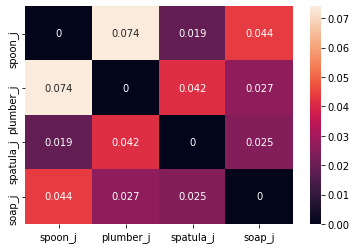

In [66]:
heatplot(jzazbz_vectors, jzazbz_vectors, jensen_shannon)

### Earth Movers Distance

From the scipy docs: The wasserstein distance is also known as the earth mover’s distance, since it can be seen as the minimum amount of “work” required to transform u into v, where “work” is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved. 

In [67]:
from scipy.stats import wasserstein_distance

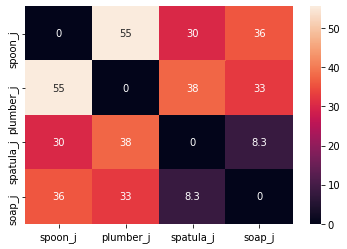

In [68]:
heatplot(jzazbz_vectors, jzazbz_vectors, wasserstein_distance)

Let's try the same metric on our word embeddings too.

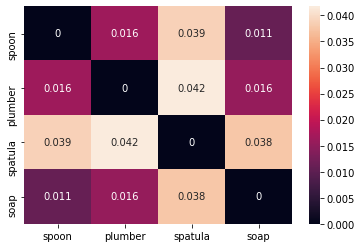

In [69]:
heatplot(word_vectors, word_vectors, wasserstein_distance)

### Loss Functions

Loss functions, which form the core of deep learning training, are also, in a sense, a way to measure between two distributions or sets of values. In fact, some of the measures and metrics we've seen above (such as KL) are used in deep learning traning. While we would be using pytorch to normally set up loss functions, since we are only going to be demonstrating them on smaller distributions, we will either write them ourselves or use numpy_ml, which includes many implementations of popular loss functions in numpy.

In [74]:
def mean_squared_error(actual, predicted):
    sum_square_error = 0.0
    for i in range(len(actual)):
        sum_square_error += (actual[i] - predicted[i])**2.0
    mean_square_error = 1.0 / len(actual) * sum_square_error
    return mean_square_error

In [75]:
def binary_cross_entropy(actual, predicted):
    sum_score = 0.0
    for i in range(len(actual)):
        sum_score += actual[i] * np.log(1e-15 + predicted[i])
    mean_sum_score = 1.0 / len(actual) * sum_score
    return -mean_sum_score

These are pseudo implementations to understand what is going on under the hood, we would recommend sticking with standard implementations on [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) or [numpy_ml](https://numpy-ml.readthedocs.io/en/latest/numpy_ml.neural_nets.losses.html) which would be optimised.

### Metric Learning

Metric learning algorithms are a suite of machine learning algorithms which learn distance metrics in order to transform a representation space into one where certain values can be brought closer to each other. Let us demonstrate this using the color vectors from before.

In [118]:
X = np.array(list(jzazbz_vectors.values())[0:3])

In [119]:
jzazbz_vectors.keys()

dict_keys(['spoon_j', 'plumber_j', 'spatula_j', 'soap_j'])

In [124]:
X

array([[1.54435967e+00, 1.10441180e+02, 9.03089444e-02, 2.32744099e+01,
        6.44408844e-01, 6.49307716e+02, 7.55834890e+00, 4.88927671e+01],
       [7.64139177e+01, 1.05413569e+02, 8.60944126e-01, 7.29411459e+01,
        3.40228267e+01, 4.27377585e+02, 5.90658556e-01, 1.24132852e+02],
       [3.56795570e+00, 1.73680453e+02, 4.32069051e-02, 4.49878928e+01,
        1.09465105e+01, 5.28656777e+02, 1.63705797e-03, 7.98690663e+01]])

In [120]:
y = np.array(['kitchen', 'cleaning', 'kitchen'])

So here, let's say we want to bring semantically closer color vectors "closer", even if they may be far away wrt color. We do that by providing these labels to the 4 vectors, and running a metric learning algorithm.

In [99]:
from metric_learn import NCA

In [121]:
nca = NCA(random_state=42)

In [122]:
nca.fit(X, y)

NCA(random_state=42)

In [113]:
soap_transformed = nca.transform(np.array(soap_jzazbz).reshape(1, -1))

In [116]:
soap_transformed

array([[1.02030221e+01, 8.47703898e+01, 3.67557829e-01, 3.46247004e+01,
        2.89229460e+01, 5.05697289e+02, 9.50040183e-01, 1.76217553e+02]])

In [123]:
nca.get_mahalanobis_matrix()

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])